# Deep Learning

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
%matplotlib inline

## Loading data 

In [3]:
df = pd.read_csv("./processed_data/processed_data/ecg_processed_data.csv", index_col=0)

In [4]:
df.head()

,Record ID,Segment Start,Segment End,0,1,2,3,4,5,6,...,191,192,193,194,195,196,197,198,199,Annotation Class
0,100,13,213,0.059449,0.055308,0.052035,0.049666,0.047961,0.046922,0.046801,...,0.029812,0.031902,0.033233,0.033981,0.034276,0.034166,0.033702,0.033134,0.032648,N
1,100,307,507,0.084239,0.087566,0.088956,0.088621,0.086919,0.084459,0.081823,...,0.020380,0.020170,0.020049,0.020272,0.020719,0.020971,0.020866,0.020622,0.020434,N
2,100,563,763,-0.006937,-0.005690,-0.005184,-0.005172,-0.005405,-0.005802,-0.006385,...,-0.083923,-0.084476,-0.084798,-0.084841,-0.084325,-0.082953,-0.080644,-0.077424,-0.073181,N
3,100,883,1083,0.072086,0.073128,0.073026,0.071802,0.069731,0.067336,0.065156,...,0.040917,0.040820,0.040605,0.040177,0.039328,0.038051,0.036671,0.035565,0.034817,N
4,100,1168,1368,0.084762,0.083995,0.082327,0.080127,0.077701,0.075216,0.072963,...,0.024691,0.025225,0.025977,0.027249,0.029211,0.031715,0.034364,0.036462,0.037443,N


In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Record ID,99174.0,170.801752,51.985347,100.000000,114.000000,203.000000,215.000000,234.000000
Segment Start,99174.0,325045.609051,188363.760147,9.000000,160745.000000,326069.500000,488528.500000,649793.000000
Segment End,99174.0,325245.609051,188363.760147,209.000000,160945.000000,326269.500000,488728.500000,649993.000000
0,99174.0,-0.042127,0.119547,-1.900955,-0.097349,-0.045074,0.006416,2.195452
1,99174.0,-0.042054,0.118728,-1.887876,-0.097490,-0.044461,0.006934,2.207827
...,...,...,...,...,...,...,...,...
195,99174.0,0.068449,0.243398,-2.685320,-0.058351,-0.001114,0.128255,2.462435
196,99174.0,0.065637,0.240538,-2.715343,-0.058428,-0.001539,0.122874,2.480217
197,99174.0,0.062668,0.237743,-2.734072,-0.058666,-0.002161,0.117917,2.494743
198,99174.0,0.059560,0.234978,-2.743276,-0.059124,-0.003069,0.112630,2.506468


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99174 entries, 0 to 99173
Columns: 204 entries, Record ID to Annotation Class
dtypes: float64(200), int64(3), object(1)
memory usage: 155.1+ MB


## Preprocessing

In [7]:
X = df[[str(i) for i in range(0, 200)]].values

In [8]:
X

array([[ 0.05944944,  0.05530813,  0.05203533, ...,  0.03370211,
         0.03313351,  0.03264835],
       [ 0.08423915,  0.08756617,  0.08895633, ...,  0.02086591,
         0.02062246,  0.02043396],
       [-0.00693746, -0.00568975, -0.00518379, ..., -0.08064385,
        -0.07742402, -0.07318052],
       ...,
       [-0.0464351 , -0.04455849, -0.04386177, ..., -0.08220224,
        -0.08951841, -0.09635549],
       [-0.09173968, -0.09411179, -0.09693917, ...,  0.01425364,
         0.01084743,  0.0081831 ],
       [ 0.07593816,  0.07788971,  0.07865438, ...,  0.05425404,
         0.04719546,  0.0410799 ]])

In [9]:
X.shape

(99174, 200)

In [10]:
y = df["Annotation Class"].astype("category")

In [11]:
y.describe()

count     99174
unique        5
top           N
freq      73439
Name: Annotation Class, dtype: object

In [12]:
y.info()

<class 'pandas.core.series.Series'>
Index: 99174 entries, 0 to 99173
Series name: Annotation Class
Non-Null Count  Dtype   
--------------  -----   
99174 non-null  category
dtypes: category(1)
memory usage: 871.9 KB


In [13]:
y.cat.codes

0        2
1        2
2        2
3        2
4        2
        ..
99169    2
99170    2
99171    2
99172    2
99173    2
Length: 99174, dtype: int8

In [14]:
y.cat.categories

Index(['/', 'L', 'N', 'R', 'V'], dtype='object')

In [15]:
y_code = y.cat.codes.values

In [16]:
y_code

array([2, 2, 2, ..., 2, 2, 2], dtype=int8)

In [17]:
y_code.shape

(99174,)

In [18]:
y_code

array([2, 2, 2, ..., 2, 2, 2], dtype=int8)

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_code, test_size=0.2, random_state=101, stratify=y, shuffle=True
)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=101, stratify=y_train, shuffle=True
)

In [22]:
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train)
y_val_tensor = torch.LongTensor(y_val)
y_test_tensor = torch.LongTensor(y_test)

In [23]:
X_train_tensor.shape

torch.Size([63471, 200])

In [24]:
X_val_tensor.shape

torch.Size([15868, 200])

## ANN

In [25]:
from ecg_deep_learning_models.models import ECGANNModel, ECGCNNModel
from ecg_deep_learning_models.utils import (
    count_parameters,
    train_model,
    eval_model,
    show_metrics,
)

In [26]:
ecg_ann_model = ECGANNModel(layers=[100, 50])
ecg_ann_model_1 = ECGANNModel(layers=[100, 50, 25])

In [27]:
count_parameters(ecg_ann_model)

 20000
   100
  5000
    50
   250
     5
______
 25405


In [28]:
count_parameters(ecg_ann_model_1)

 20000
   100
  5000
    50
  1250
    25
   125
     5
______
 26555


In [29]:
ecg_ann_model

ECGANNModel(
  (layers): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=50, out_features=5, bias=True)
  )
)

In [30]:
ecg_ann_model_1

ECGANNModel(
  (layers): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=50, out_features=25, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=25, out_features=5, bias=True)
  )
)

In [31]:
ecg_ann_model.parameters()

<generator object Module.parameters at 0x7ff6f2148ac0>

In [32]:
ecg_ann_model_1.parameters()

<generator object Module.parameters at 0x7ff6f21485f0>

In [33]:
ecg_ann_model.parameters

<bound method Module.parameters of ECGANNModel(
  (layers): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=50, out_features=5, bias=True)
  )
)>

In [34]:
ecg_ann_model_1.parameters

<bound method Module.parameters of ECGANNModel(
  (layers): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=100, out_features=50, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=50, out_features=25, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=25, out_features=5, bias=True)
  )
)>

In [35]:
train_accuracies, test_accuracies, train_mean_losses, test_mean_losses = train_model(
    model=ecg_ann_model,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_test=X_val_tensor,
    y_test=y_val_tensor,
    learning_rate=0.001,
    batch_size=100,
    val_batch_size=100,
    epochs=30,
)

epoch:1	Train Loss:        0.46	Train Accuracy:       85.47	Test Loss:        0.18	Test Accuracy:       95.03	 Tolerance Count:0
epoch:2	Train Loss:        0.24	Train Accuracy:       92.77	Test Loss:        0.12	Test Accuracy:       96.61	 Tolerance Count:0
epoch:3	Train Loss:        0.20	Train Accuracy:       94.22	Test Loss:        0.10	Test Accuracy:       97.38	 Tolerance Count:0
epoch:4	Train Loss:        0.17	Train Accuracy:       94.92	Test Loss:        0.09	Test Accuracy:       97.55	 Tolerance Count:0
epoch:5	Train Loss:        0.16	Train Accuracy:       95.37	Test Loss:        0.08	Test Accuracy:       97.83	 Tolerance Count:0
epoch:6	Train Loss:        0.15	Train Accuracy:       95.76	Test Loss:        0.08	Test Accuracy:       98.04	 Tolerance Count:0
epoch:7	Train Loss:        0.14	Train Accuracy:       95.96	Test Loss:        0.07	Test Accuracy:       98.15	 Tolerance Count:0
epoch:8	Train Loss:        0.14	Train Accuracy:       96.10	Test Loss:        0.07	Test Accuracy:

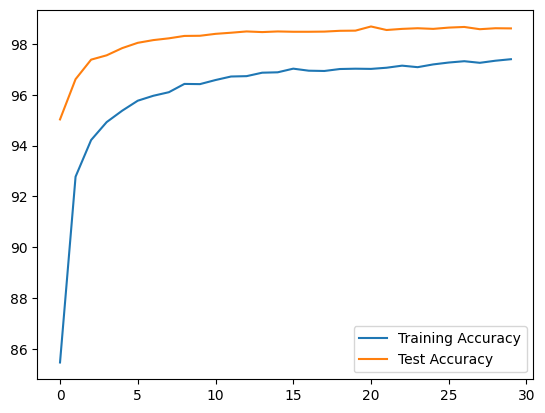

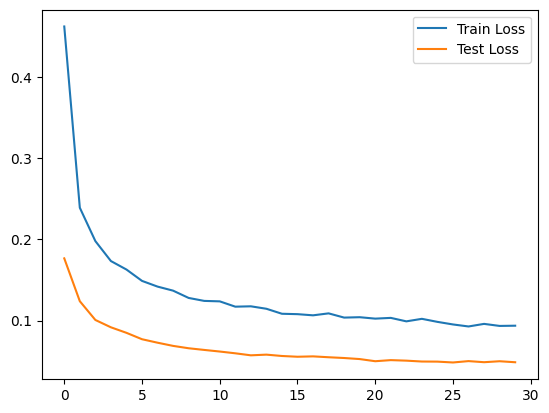

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       722
           1       0.97      0.98      0.98      1596
           2       0.99      0.99      0.99     14711
           3       0.99      0.99      0.99      1448
           4       0.94      0.94      0.94      1358

    accuracy                           0.99     19835
   macro avg       0.98      0.98      0.98     19835
weighted avg       0.99      0.99      0.99     19835

[[  720     0     1     0     1]
 [    0  1567    16     0    13]
 [    0    27 14605    18    61]
 [    0     2    11  1432     3]
 [    4    18    55     1  1280]]


(98.8353919838669, 0.04405689239501953)

In [36]:
show_metrics(train_accuracies, test_accuracies, train_mean_losses, test_mean_losses)
eval_model(ecg_ann_model, X_test_tensor, y_test_tensor)

In [37]:
train_accuracies, test_accuracies, train_mean_losses, test_mean_losses = train_model(
    model=ecg_ann_model_1,
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_test=X_val_tensor,
    y_test=y_val_tensor,
    learning_rate=0.001,
    batch_size=100,
    val_batch_size=100,
    epochs=30,
)

epoch:1	Train Loss:        0.58	Train Accuracy:       79.59	Test Loss:        0.24	Test Accuracy:       93.40	 Tolerance Count:0
epoch:2	Train Loss:        0.32	Train Accuracy:       89.95	Test Loss:        0.16	Test Accuracy:       95.37	 Tolerance Count:0
epoch:3	Train Loss:        0.26	Train Accuracy:       92.12	Test Loss:        0.12	Test Accuracy:       96.41	 Tolerance Count:0
epoch:4	Train Loss:        0.23	Train Accuracy:       93.30	Test Loss:        0.11	Test Accuracy:       96.87	 Tolerance Count:0
epoch:5	Train Loss:        0.21	Train Accuracy:       93.80	Test Loss:        0.10	Test Accuracy:       97.15	 Tolerance Count:0
epoch:6	Train Loss:        0.20	Train Accuracy:       94.33	Test Loss:        0.09	Test Accuracy:       97.27	 Tolerance Count:0
epoch:7	Train Loss:        0.18	Train Accuracy:       94.72	Test Loss:        0.09	Test Accuracy:       97.56	 Tolerance Count:0
epoch:8	Train Loss:        0.18	Train Accuracy:       94.81	Test Loss:        0.08	Test Accuracy:

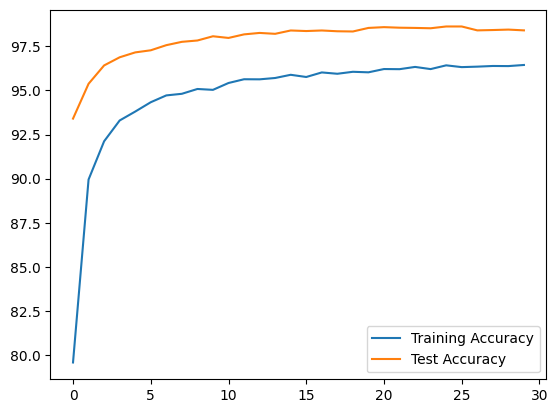

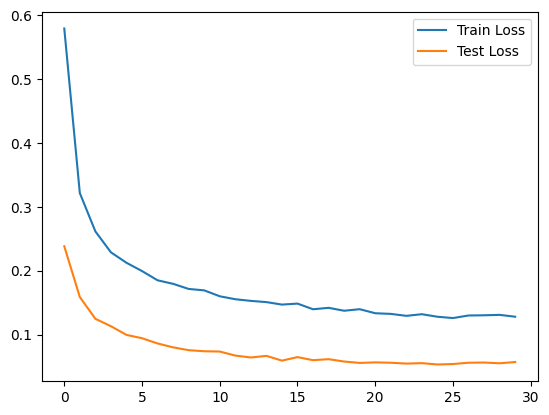

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       718
           1       0.97      0.97      0.97      1613
           2       0.99      0.99      0.99     14723
           3       0.98      0.99      0.98      1440
           4       0.93      0.94      0.93      1341

    accuracy                           0.99     19835
   macro avg       0.97      0.98      0.97     19835
weighted avg       0.99      0.99      0.99     19835

[[  716     0     0     0     2]
 [    0  1566    37     0    10]
 [    1    17 14602    26    77]
 [    0     0     8  1421    11]
 [    7    31    41     4  1258]]


(98.62868666498613, 0.04941364377737045)

In [38]:
show_metrics(train_accuracies, test_accuracies, train_mean_losses, test_mean_losses)
eval_model(ecg_ann_model_1, X_test_tensor, y_test_tensor)

## CNN

In [39]:
ecg_cnn_model = ECGCNNModel()

In [40]:
count_parameters(ecg_cnn_model)

    48
    16
  1536
    32
    32
    32
  6144
    64
 24576
   128
   128
   128
2432000
   100
  5000
    50
   250
     5
______
2470269


In [41]:
train_accuracies, test_accuracies, train_mean_losses, test_mean_losses = train_model(
    model=ecg_cnn_model,
    X_train=X_train_tensor.reshape(-1, 1, 200),
    y_train=y_train_tensor,
    X_test=X_val_tensor.reshape(-1, 1, 200),
    y_test=y_val_tensor,
    learning_rate=0.001,
    batch_size=100,
    val_batch_size=100,
    epochs=6,
)

epoch:1	Train Loss:        0.21	Train Accuracy:       93.47	Test Loss:        0.05	Test Accuracy:       98.58	 Tolerance Count:0
epoch:2	Train Loss:        0.08	Train Accuracy:       97.75	Test Loss:        0.04	Test Accuracy:       98.97	 Tolerance Count:0
epoch:3	Train Loss:        0.06	Train Accuracy:       98.20	Test Loss:        0.04	Test Accuracy:       99.17	 Tolerance Count:0
epoch:4	Train Loss:        0.06	Train Accuracy:       98.45	Test Loss:        0.04	Test Accuracy:       98.99	 Tolerance Count:0
epoch:5	Train Loss:        0.05	Train Accuracy:       98.71	Test Loss:        0.03	Test Accuracy:       99.31	 Tolerance Count:0
epoch:6	Train Loss:        0.04	Train Accuracy:       98.84	Test Loss:        0.04	Test Accuracy:       98.92	 Tolerance Count:0

Duration: 733 seconds


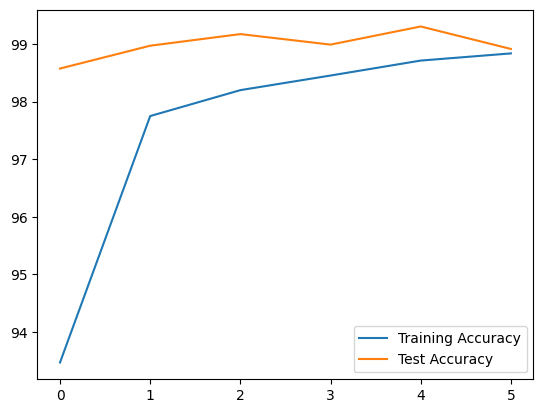

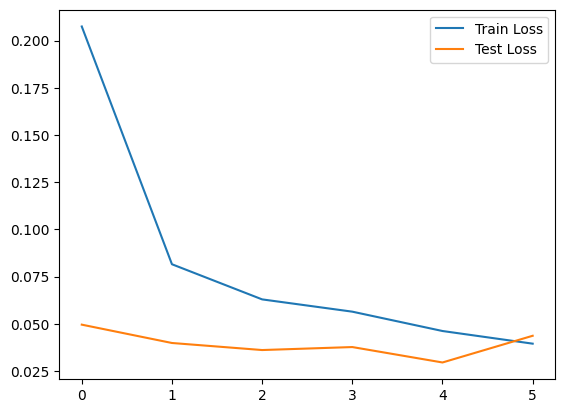

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       726
           1       0.94      1.00      0.97      1527
           2       1.00      0.99      0.99     14827
           3       0.99      0.99      0.99      1446
           4       0.94      0.98      0.96      1309

    accuracy                           0.99     19835
   macro avg       0.97      0.99      0.98     19835
weighted avg       0.99      0.99      0.99     19835

[[  724     1     1     0     0]
 [    0  1524     2     0     1]
 [    0    71 14667    13    76]
 [    0     0     4  1438     4]
 [    0    18    14     0  1277]]


(98.96647340559616, 0.04281345009803772)

In [42]:
show_metrics(train_accuracies, test_accuracies, train_mean_losses, test_mean_losses)
eval_model(ecg_cnn_model, X_test_tensor.reshape(-1, 1, 200), y_test_tensor)